# Stereo pair (SAD)
Stereo block matching algorithm using Sum of Absolute Differences (SAD) to compute a disparity map from a stereo image pair.

The result is a grayscale image where pixel intensity represents disparity (the horizontal shift between left and right views), which is a key step toward estimating depth from stereo vision.

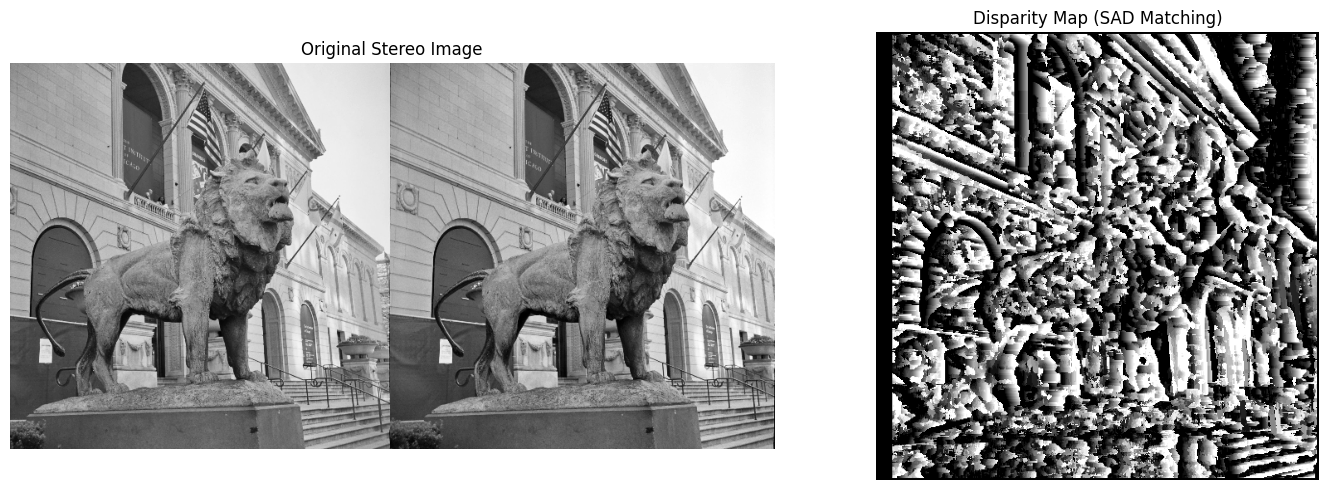

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a stereo image pair (assumed to be concatenated side by side) in grayscale
image_path = "stereo_pair.jpg"  
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Resize for faster processing (especially useful when debugging)
img = cv2.resize(img, (img.shape[1] // 3, img.shape[0] // 3))

h_0, w_0 = img.shape

# Split into left and right images
imgL = img[:, 0:w_0 // 2]   # Left image
imgR = img[:, w_0 // 2:w_0]  # Right image

# Convert to grayscale if not already (safety check)
if len(imgL.shape) == 3:
    imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
if len(imgR.shape) == 3:
    imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

# Parameters
window_size = 5       # Size of comparison window
max_disp = 15         # Maximum disparity (how far to shift for matching)

h, w = imgL.shape
half = window_size // 2  # Number of pixels around the center of the window
disparity_map = np.zeros((h, w), dtype=np.uint8)  # Output disparity map (grayscale)

# Loop through each pixel (ignoring image borders)
'''
Avoid border pixels so the window doesn't go out of image bounds.
Also, ensure we don't shift past the left edge of the right image by limiting x.
'''
for y in range(half, h - half):
    for x in range(half + max_disp, w - half):
        best_offset = 0
        min_sad = float('inf')  # Initialize SAD to infinity for comparison

        # Loop through each possible disparity value
        for d in range(max_disp + 1):
            sad = 0  # SAD = Sum of Absolute Differences

            # Loop over the window around pixel (x, y)
            for i in range(-half, half + 1):  # i = {-2,-1,0,1,2}
                for j in range(-half, half + 1):
                    pL = int(imgL[y + i, x + j])          # Pixel from left image
                    pR = int(imgR[y + i, x + j - d])      # Corresponding pixel from right image shifted by d
                    sad += abs(pL - pR)                   # Accumulate absolute difference

            # Keep the disparity with the lowest SAD (best match)
            if sad < min_sad:
                min_sad = sad
                best_offset = d

        # Normalize disparity value to [0, 255] and save to disparity map
        disparity_map[y, x] = int((best_offset / max_disp) * 255)

plt.figure(figsize=(15, 5))

# Show original stereo pair
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Stereo Image')
plt.axis('off')

# Show disparity map
plt.subplot(1, 2, 2)
plt.imshow(disparity_map, cmap='gray')
plt.title('Disparity Map (SAD Matching)')
plt.axis('off')

plt.tight_layout()
plt.show()



1. why use the grayscale img better than the color img

a. reducing the number of computations

If we keep the color image, each pixel has 3 values (B, G, R), meaning we need to compute disparity for 3 separate channels and then merge them.
When converting to grayscale, each pixel has only 1 value, reducing the number of computations by three times, making the algorithm run faster.

b. Increasing Disparity Accuracy 
If we consider color channels, some objects with similar colors but different brightness levels can be misidentified as the same object.

2. to find the best corresponding point between the two images in a stereo pair--> we need to chose the disparity u that minimizes the matching cost 
D(u)

Because the corresponding point in the two images (left and right) will have the most similar context, pixel intensity, and texture,
--> the sum of absolute differences (SAD) between the two windows at that position will be the smallest.



